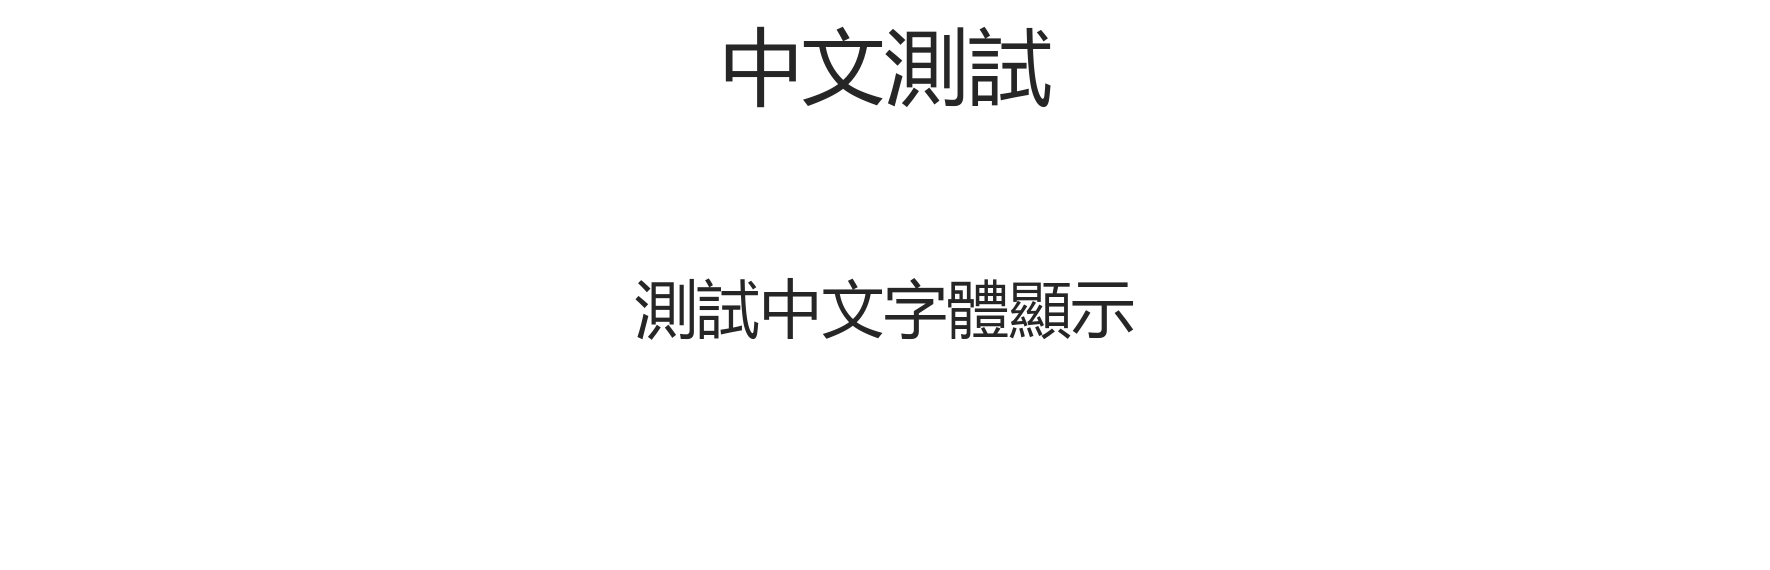

如果你在圖中看到中文，則字體設定正確


In [ ]:
import time
import re  
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models
import guidedlda

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 繪圖設定
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False



In [8]:
df = pd.read_csv('chiikawa_unified_data.csv')
print(df.head())

   system_id dataSource                                       artUrl  \
0          1         YT  https://www.youtube.com/watch?v=3fmZbTHG8us   
1          2         YT  https://www.youtube.com/watch?v=kcilIzr7Bf0   
2          3         YT  https://www.youtube.com/watch?v=6EtTJFbRRaE   
3          4         YT  https://www.youtube.com/watch?v=r4ZtjfGZQaA   
4          5         YT  https://www.youtube.com/watch?v=uFynuUT3mHI   

               artDate                                     artTitle  \
0  2024-07-06 18:46:55                                   小八跳舞 #吉伊卡哇   
1  2024-07-07 04:48:58       【Chiikawa】睡衣派對之歌 / パジャマパーティーズのうた 廣東話歌詞   
2  2024-07-08 07:07:35                【🔴Live直播】開箱華山快閃店！「史努比、吉伊卡哇」萌翻   
3  2024-07-15 03:07:46         【突發LA】迫不及待的盲抽🌟拆熱騰騰剛到的吉伊卡哇卡牌盲包🐺 #森森鈴蘭   
4  2024-07-16 14:27:08  【戰利品開箱LA】笑死 買到沒錢💸 #森森鈴蘭 #吉伊卡哇 #我要記得宣傳演唱會RRR   

                                          artContent  \
0                                         小八跳舞 #吉伊卡哇   
1  【Chiikawa】睡衣派對之歌 / パジャマパー

In [9]:
# 設定jieba的字典和使用者自定義詞典
jieba.set_dictionary('dict/dict.txt.big')  # 使用繁體中文字典

# 新增特定領域詞彙到自定義詞典
custom_words = [
    # 主要名稱
    "Chiikawa", "吉伊卡哇", "ちいかわ", "吉伊", "小可愛", "吉依", "寶寶",
    
    # 主要角色
    "小八貓", "ハチワレ", "Hachiware", "八字瀏海", "小八", "藍色褲頭貓", "哈奇" , "哈吉",
    "兔兔", "うさぎ", "Usagi", "烏薩奇", "兔哥", "537",
    "小桃", "モモンガ", "Momonga", "飛鼠",
    "海獺勇者", "ラッコ", "Rakko",
    "栗子饅頭", "くりまんじゅう", "Kuri-Manjuu", "前輩",
    
    # 其他角色
    "風獅", "シーサー", "Shisa", "獅薩",
    "拉麵鎧甲人", "手拿包鎧甲人", "勞動鎧甲人", "鎧甲人",
    "睡衣派對", "パジャマパーティーズ", "哥布林",
    
    # 特殊詞彙
    "吉伊卡哇構文", "除草考試", "除草檢定", "小可愛族",
    "郎拉麵店", "三級除草證件", "討伐", "抽獎運",
    
    # 特性描述
    "膽小鬼", "愛哭鬼", "療癒", "二頭身", "啊哈", "吖哈",
    "又小又可愛", "なんか小さくてかわいいやつ",
    
    # 創作相關
    "Nagano", "ナガノ", "動畫工房", "周邊商品", "貼圖", "一番賞"
]

for word in custom_words:
    jieba.add_word(word, freq=100)  # 給予較高詞頻以確保能被切分出來

# 建立角色同義詞映射表
character_synonyms = {
    # 主角同義詞映射
    "ちいかわ": "吉伊卡哇", "Chiikawa": "吉伊卡哇", "吉伊": "吉伊卡哇", 
    "小可愛": "吉伊卡哇", "吉依": "吉伊卡哇",
    
    # 小八貓同義詞映射
    "ハチワレ": "小八貓", "Hachiware": "小八貓", "八字瀏海": "小八貓", 
    "小八": "小八貓", "藍色褲頭貓": "小八貓", "哈奇": "小八貓", "哈吉": "小八貓",
    
    # 兔兔同義詞映射
    "うさぎ": "兔兔", "Usagi": "兔兔", "烏薩奇": "兔兔", 
    "兔哥": "兔兔", "537": "兔兔",
    
    # 其他角色同義詞映射
    "モモンガ": "小桃", "Momonga": "小桃", "飛鼠": "小桃",
    "ラッコ": "海獺勇者", "Rakko": "海獺勇者",
    "くりまんじゅう": "栗子饅頭", "Kuri-Manjuu": "栗子饅頭", "前輩": "栗子饅頭",
    "シーサー": "風獅", "Shisa": "風獅", "獅薩": "風獅",
    "パジャマパーティーズ": "睡衣派對", "哥布林": "睡衣派對"
}

# 新增保留字詞
new_compounds = [
    # 角色/品牌相關詞組
    "吉伊卡哇", "烏薩奇", "小八貓", "小可愛",
    
    # 商品/活動相關詞組
    "代購吉伊卡哇", "一番賞", "周邊商品"
]

# 為這些詞組設定較高詞頻
for word in new_compounds:
    jieba.add_word(word, freq=1000)  # 給予高詞頻

# 載入停用詞
def load_stopwords(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            stopwords = [line.strip() for line in f.readlines()]
        return set(stopwords)
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='big5') as f:
            stopwords = [line.strip() for line in f.readlines()]
        return set(stopwords)
    except Exception as e:
        print(f"讀取停用詞檔案時發生錯誤: {e}")
        return set()

# 讀取停用詞
stopwords_path = "./dict/stopwords.txt"  
stopwords = load_stopwords(stopwords_path)
print(f"已載入 {len(stopwords)} 個停用詞")

# 新增自定義停用詞
custom_stopwords = [
    # 代詞
    "我", "你", "他", "她", "它", "我們", "你們", "他們", "她們", "它們", "這", "那", "這些", "那些", "誰", "什麼", "哪", "哪裡", "哪兒", "怎麼", "怎樣", "如何",
    
    # 連接詞
    "和", "與", "而", "並", "或", "但", "但是", "然而", "所以", "因為", "因此", "如果", "雖然", "即使", "無論", "只要", "不論", "假如", "若", "若是",
    
    # 助詞
    "的", "地", "得", "了", "著", "過", "吧", "嗎", "呢", "啊", "哦", "喔", "呀", "耶", "哎", "唉", "嗯", "嘿",
    
    # 副詞
    "很", "非常", "極", "太", "更", "最", "又", "也", "都", "還", "只", "就", "才", "剛", "曾", "已", "將", "不", "沒", "別", "莫", "勿",
    
    # 介詞
    "在", "從", "向", "往", "於", "對", "給", "為", "替", "由", "把", "被", "讓", "使", "隨", "跟", "靠", "據", "至", "到", "自",
    
    # 數量詞
    "一", "二", "三", "四", "五", "六", "七", "八", "九", "十", "百", "千", "萬", "億", "兆", "個", "些", "每", "某", "各", "整", "全", "多", "少", "幾",
    
    # 時間詞
    "年", "月", "日", "時", "分", "秒", "天", "週", "季", "今", "昨", "明", "前", "後", "當", "正", "現", "曾", "已", "將", "會", "常", "永",
    
    # 方位詞
    "上", "下", "左", "右", "前", "後", "內", "外", "中", "東", "西", "南", "北", "中間", "旁邊", "附近", "周圍",
    
    # 常用動詞
    "是", "有", "無", "來", "去", "做", "看", "聽", "說", "想", "要", "能", "會", "可以", "應該", "必須", "需要", "得", "獲", "取", "予",
    
    # 常用形容詞
    "好", "壞", "大", "小", "多", "少", "高", "低", "長", "短", "新", "舊", "快", "慢", "遠", "近", "輕", "重", "深", "淺",
    
    # 其他常見虛詞
    "之", "乎", "以", "其", "所", "者", "矣", "焉", "哉", "也", "然", "否", "兮", "乃", "且", "為", "則", "再", "又", "此", "夫", "亦",
    
    # 常見短語
    "一個", "這個", "那個", "一些", "這些", "那些", "一下", "一點", "一直", "一定", "一般", "一樣", "不過", "不必", "不要", "可能", "可是", "只是", "就是", "如此", "如果", "這樣", "那樣", "這麼", "那麼", "因此", "所以", "然後", "接著", "其實", "其中", "其他", "其它", "之前", "之後", "之中", "之間",
    
    # 網路用語
    "http", "www", "com", "cn", "org", "net", "html", "htm", "php", "jpg", "png", "gif", ".."
]
stopwords.update(custom_stopwords)



Building prefix dict from g:\我的雲端硬碟\I want to graduate I want to graduate\二下\SMA\SMA_final\dict\dict.txt.big ...
2025-05-01 13:07:09,575 : DEBUG : Building prefix dict from g:\我的雲端硬碟\I want to graduate I want to graduate\二下\SMA\SMA_final\dict\dict.txt.big ...
Loading model from cache C:\Users\qqw12\AppData\Local\Temp\jieba.u5b75d4bc912d0a353138fdc294f176b2.cache
2025-05-01 13:07:09,592 : DEBUG : Loading model from cache C:\Users\qqw12\AppData\Local\Temp\jieba.u5b75d4bc912d0a353138fdc294f176b2.cache
Loading model cost 1.144 seconds.
2025-05-01 13:07:10,720 : DEBUG : Loading model cost 1.144 seconds.
Prefix dict has been built successfully.
2025-05-01 13:07:10,723 : DEBUG : Prefix dict has been built successfully.


已載入 1211 個停用詞


In [10]:
def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return []
    
    # 將多個連續換行符替換為句號
    text = re.sub(r'\n\n', '。', text)
    # 將單個換行符替換為逗號
    text = re.sub(r'\n', '，', text)
    # 移除網址
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    # 統一標點符號，移除表情符號和特殊符號
    text = re.sub(r'[^\u4e00-\u9fff\s.,!?;:、，。！？；：]', '', text)
    # 統一全半形符號
    text = text.replace('，', ',').replace('。', '.').replace('！', '!').replace('？', '?')
    
    # 使用jieba進行斷詞
    words = jieba.lcut(text)
    
    # 過濾停用詞和單字元詞，並進行同義詞替換
    filtered_words = []
    for word in words:
        if word not in stopwords and len(word.strip()) > 1:
            # 同義詞替換
            if word in character_synonyms:
                word = character_synonyms[word]
            filtered_words.append(word)
    
    return filtered_words

# 對文本進行處理
df['tokenized_text'] = df['artContent'].apply(preprocess_text)

# 只保留非空的文本
df = df[df['tokenized_text'].map(len) > 0]

In [11]:
# 創建字典
dictionary = Dictionary(df['tokenized_text'])

# 過濾極端頻率的詞
dictionary.filter_extremes(no_below=5, no_above=0.8)  # 至少在5個文檔中出現，最多在80%的文檔中出現
print(f"過濾後的字典大小: {len(dictionary)}")

# 創建詞袋模型
corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]

# 使用TF-IDF進行加權
from gensim.models import TfidfModel
tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

# 顯示前5個文檔的TF-IDF向量
print("前5個文檔的TF-IDF向量:")
for i, doc_tfidf in enumerate(tfidf_corpus[:5]):
    print(f"文檔 {i+1}: {doc_tfidf[:5]}")  # 只顯示前5個詞的權重


2025-05-01 13:07:36,359 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-05-01 13:07:36,984 : INFO : adding document #10000 to Dictionary<37559 unique tokens: ['吉伊卡哇', '小八貓', '跳舞', '一千萬', '中文歌詞']...>
2025-05-01 13:07:37,138 : INFO : built Dictionary<38886 unique tokens: ['吉伊卡哇', '小八貓', '跳舞', '一千萬', '中文歌詞']...> from 12446 documents (total 627556 corpus positions)
2025-05-01 13:07:37,139 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<38886 unique tokens: ['吉伊卡哇', '小八貓', '跳舞', '一千萬', '中文歌詞']...> from 12446 documents (total 627556 corpus positions)", 'datetime': '2025-05-01T13:07:37.139681', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-05-01 13:07:37,191 : INFO : discarding 29520 tokens: [('吉伊卡哇', 10861), ('一千萬', 3), ('中文歌詞', 2), ('交完', 2), ('仲差', 2), ('協調', 4), ('嗚哇華', 2), ('嗚哇話', 2), ('嗚壞', 2), ('嗚話', 2)]...

過濾後的字典大小: 9366


2025-05-01 13:07:37,588 : INFO : collecting document frequencies
2025-05-01 13:07:37,589 : INFO : PROGRESS: processing document #0
2025-05-01 13:07:37,640 : INFO : PROGRESS: processing document #10000
2025-05-01 13:07:37,671 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 12446 documents and 9366 features (395066 matrix non-zeros)', 'datetime': '2025-05-01T13:07:37.670712', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'initialize'}


前5個文檔的TF-IDF向量:
文檔 1: [(0, 0.2542691686881161), (1, 0.9671334912278937)]
文檔 2: [(1, 0.07958514711405859), (2, 0.08330951544190018), (3, 0.08848309230444493), (4, 0.07700452073134853), (5, 0.028393735072571376)]
文檔 3: [(10, 0.2030800564288736), (13, 0.2456364305146886), (17, 0.1284786590356625), (18, 0.06395941589675032), (19, 0.06914002955684331)]
文檔 4: [(50, 0.042206180809967776), (63, 0.07292537346849368), (64, 0.11312841637371733), (65, 0.06014808912654271), (66, 0.09278365671672917)]
文檔 5: [(50, 0.04207592764827735), (60, 0.0596585993853956), (63, 0.07270031732080538), (64, 0.11277928897988719), (65, 0.05996246515801439)]


2025-05-01 13:07:41,063 : INFO : using symmetric alpha at 0.5
2025-05-01 13:07:41,065 : INFO : using symmetric eta at 0.5
2025-05-01 13:07:41,092 : INFO : using serial LDA version on this node
2025-05-01 13:07:41,103 : INFO : running online LDA training, 2 topics, 10 passes over the supplied corpus of 12446 documents, updating every 8000 documents, evaluating every ~12446 documents, iterating 50x with a convergence threshold of 0.001000
2025-05-01 13:07:41,116 : INFO : training LDA model using 4 processes


訓練 2 個主題的LDA模型...


2025-05-01 13:07:46,171 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:07:46,181 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:07:46,193 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:07:46,209 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:07:46,221 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:07:46,233 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:07:46,234 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:07:47,688 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 2, Coherence: 0.5103, Perplexity: -7.2654
訓練 4 個主題的LDA模型...


2025-05-01 13:08:18,939 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:08:18,950 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:08:18,964 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:08:18,979 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:08:18,991 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:08:19,004 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:08:19,006 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:08:20,263 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 4, Coherence: 0.5111, Perplexity: -7.0645
訓練 6 個主題的LDA模型...


2025-05-01 13:08:53,227 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:08:53,237 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:08:53,249 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:08:53,266 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:08:53,284 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:08:53,297 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:08:53,299 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:08:54,534 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 6, Coherence: 0.4760, Perplexity: -6.9743
訓練 8 個主題的LDA模型...


2025-05-01 13:09:27,793 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:09:27,804 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:09:27,804 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:09:27,828 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:09:27,844 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:09:27,859 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:09:27,860 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:09:29,095 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 8, Coherence: 0.4170, Perplexity: -6.9215
訓練 10 個主題的LDA模型...


2025-05-01 13:10:02,278 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:10:02,289 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:10:02,303 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:10:02,322 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:10:02,335 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:10:02,356 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:10:02,357 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:10:03,530 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 10, Coherence: 0.4420, Perplexity: -6.8887
訓練 12 個主題的LDA模型...


2025-05-01 13:10:38,761 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:10:38,780 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:10:38,800 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:10:38,824 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:10:38,849 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:10:38,878 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:10:38,880 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:10:40,417 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 12, Coherence: 0.4778, Perplexity: -6.8531
訓練 14 個主題的LDA模型...


2025-05-01 13:11:14,713 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:11:14,726 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:11:14,740 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:11:14,759 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:11:14,773 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:11:14,789 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:11:14,790 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:11:15,943 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 14, Coherence: 0.4403, Perplexity: -6.8195
訓練 16 個主題的LDA模型...


2025-05-01 13:11:49,203 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:11:49,214 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:11:49,228 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:11:49,245 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:11:49,259 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:11:49,275 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:11:49,277 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:11:50,546 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 16, Coherence: 0.4301, Perplexity: -6.7995
訓練 18 個主題的LDA模型...


2025-05-01 13:12:24,102 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:12:24,113 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:12:24,127 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:12:24,128 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:12:24,144 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:12:24,164 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:12:24,185 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:12:25,655 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 18, Coherence: 0.4754, Perplexity: -6.7403
訓練 20 個主題的LDA模型...


2025-05-01 13:12:59,956 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/12446, outstanding queue size 1
2025-05-01 13:12:59,968 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/12446, outstanding queue size 2
2025-05-01 13:12:59,981 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/12446, outstanding queue size 3
2025-05-01 13:12:59,997 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/12446, outstanding queue size 4
2025-05-01 13:13:00,017 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/12446, outstanding queue size 5
2025-05-01 13:13:00,035 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/12446, outstanding queue size 6
2025-05-01 13:13:00,036 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #12446/12446, outstanding queue size 7
2025-05-01 13:13:01,317 : INFO : merging changes from 8000 documents into a model of 12446 documents
2025-05

主題數量: 20, Coherence: 0.4893, Perplexity: -6.7052
LDA模型訓練和評估完成，耗時: 350.59秒


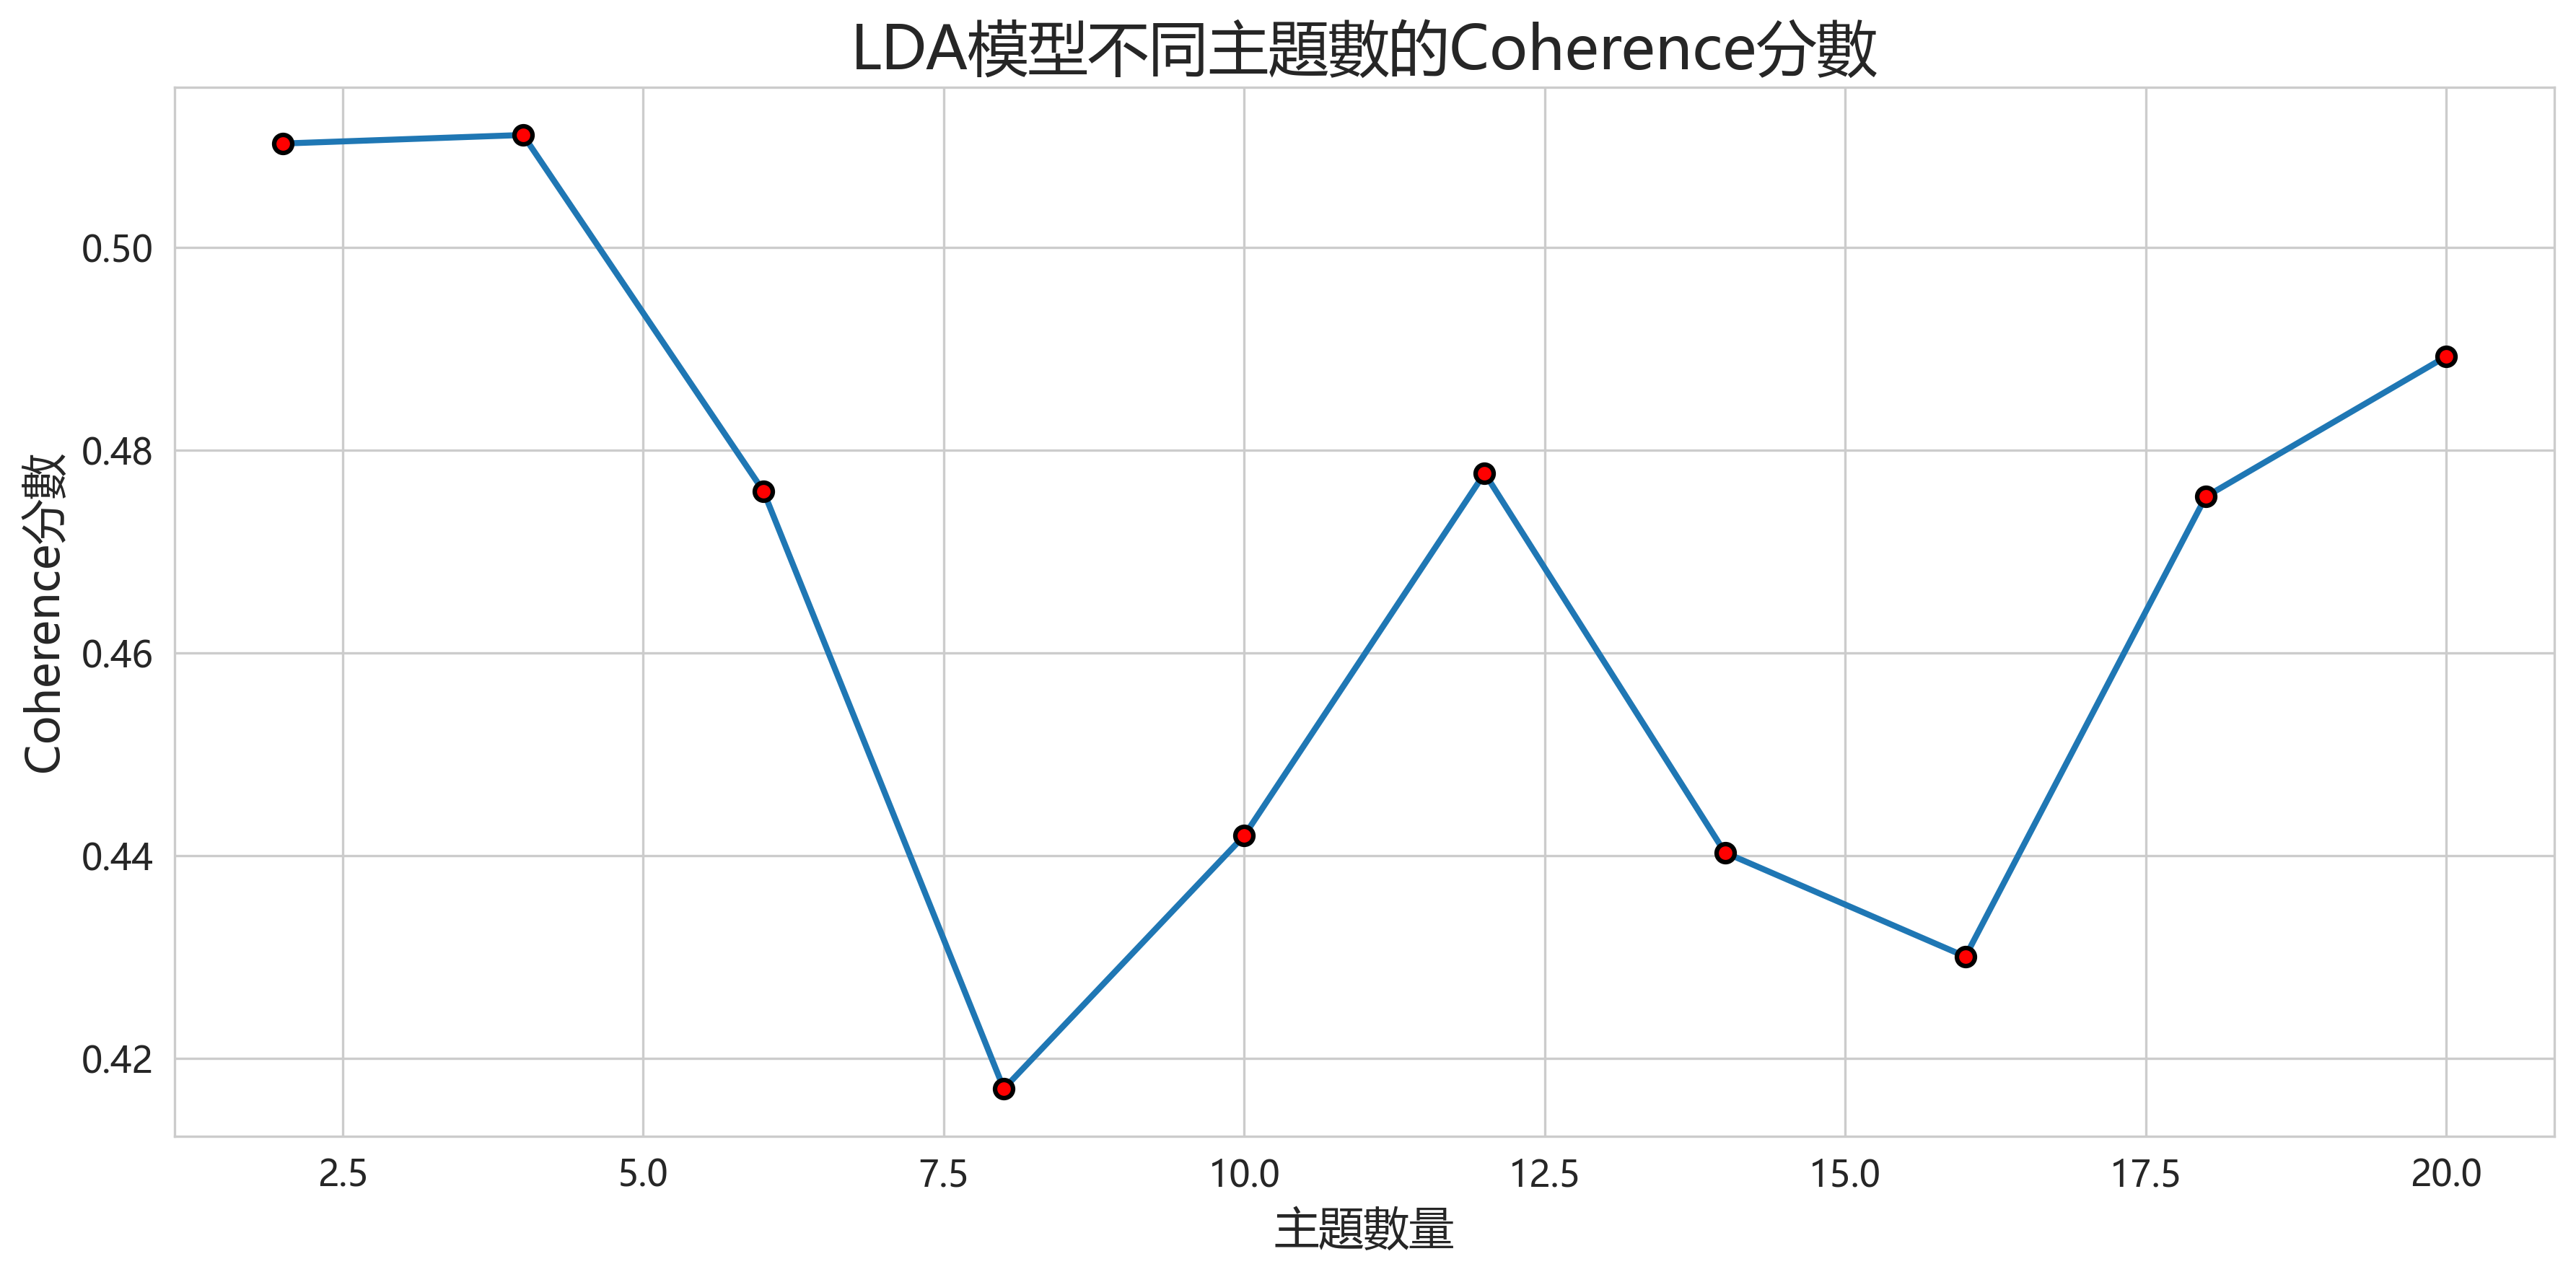

2025-05-01 13:13:32,149 : INFO : topic #0 (0.250): 0.014*"可愛" + 0.010*"日本" + 0.008*"美食" + 0.007*"兔兔" + 0.007*"小八貓" + 0.005*"角色" + 0.005*"活動" + 0.005*"聯名" + 0.005*"限定" + 0.005*"真的"
2025-05-01 13:13:32,207 : INFO : topic #1 (0.250): 0.057*"銅鑼灣" + 0.052*"日本" + 0.045*"代購" + 0.041*"公仔" + 0.037*"玩具" + 0.022*"對面" + 0.019*"精品" + 0.019*"香港" + 0.018*"旺角" + 0.017*"購物"
2025-05-01 13:13:32,208 : INFO : topic #2 (0.250): 0.046*"日本" + 0.040*"代購" + 0.022*"兔兔" + 0.015*"小八貓" + 0.015*"公仔" + 0.009*"下單" + 0.009*"網站" + 0.008*"現貨" + 0.008*"貨品" + 0.007*"小桃"
2025-05-01 13:13:32,209 : INFO : topic #3 (0.250): 0.030*"蛋糕" + 0.030*"迷因" + 0.027*"喜歡" + 0.027*"追蹤" + 0.024*"壽司" + 0.017*"扭蛋" + 0.015*"翻譯" + 0.008*"人生" + 0.008*"梗圖" + 0.008*"世界"


最佳主題數量: 4, Coherence分數: 0.5111
最佳LDA模型的主題:
主題 #0: 0.014*"可愛" + 0.010*"日本" + 0.008*"美食" + 0.007*"兔兔" + 0.007*"小八貓" + 0.005*"角色" + 0.005*"活動" + 0.005*"聯名" + 0.005*"限定" + 0.005*"真的"
主題 #1: 0.057*"銅鑼灣" + 0.052*"日本" + 0.045*"代購" + 0.041*"公仔" + 0.037*"玩具" + 0.022*"對面" + 0.019*"精品" + 0.019*"香港" + 0.018*"旺角" + 0.017*"購物"
主題 #2: 0.046*"日本" + 0.040*"代購" + 0.022*"兔兔" + 0.015*"小八貓" + 0.015*"公仔" + 0.009*"下單" + 0.009*"網站" + 0.008*"現貨" + 0.008*"貨品" + 0.007*"小桃"
主題 #3: 0.030*"蛋糕" + 0.030*"迷因" + 0.027*"喜歡" + 0.027*"追蹤" + 0.024*"壽司" + 0.017*"扭蛋" + 0.015*"翻譯" + 0.008*"人生" + 0.008*"梗圖" + 0.008*"世界"


In [12]:
# 設定主題數量範圍進行評估
topic_range = range(2, 21, 2)  # 從2到20，步長為2
coherence_scores = []
perplexity_scores = []
models = []

start = time.time()
for num_topics in topic_range:
    print(f"訓練 {num_topics} 個主題的LDA模型...")
    
    # 訓練LDA模型
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        workers=4,  # 使用多核心加速
        passes=10,  # 迭代次數
        random_state=42
    )
    
    # 計算coherence分數
    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=df['tokenized_text'], 
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    
    # 計算perplexity分數
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity)
    
    models.append(lda_model)
    
    print(f"主題數量: {num_topics}, Coherence: {coherence:.4f}, Perplexity: {perplexity:.4f}")

end = time.time()
print(f"LDA模型訓練和評估完成，耗時: {end - start:.2f}秒")

# 繪製coherence分數的變化圖
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores, 'o-')
plt.title('LDA模型不同主題數的Coherence分數')
plt.xlabel('主題數量')
plt.ylabel('Coherence分數')
plt.grid(True)
plt.show()

# 找出最佳主題數量
best_index = coherence_scores.index(max(coherence_scores))
best_num_topics = topic_range[best_index]
best_model = models[best_index]

print(f"最佳主題數量: {best_num_topics}, Coherence分數: {coherence_scores[best_index]:.4f}")

# 顯示最佳模型的主題
print("最佳LDA模型的主題:")
for topic_id, topic in best_model.print_topics(num_words=10):
    print(f"主題 #{topic_id}: {topic}")


d:\anaconda\envs\tf1_env\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


LDA視覺化結果已保存到 'lda_visualization.html'
前5篇文章的主題分布:
    Topic 0   Topic 1   Topic 2   Topic 3
0  0.089094  0.084217  0.742696  0.083992
1       NaN       NaN  0.972817       NaN
2  0.980405  0.012275       NaN       NaN
3  0.702713       NaN       NaN  0.288688
4  0.699105       NaN       NaN  0.292441


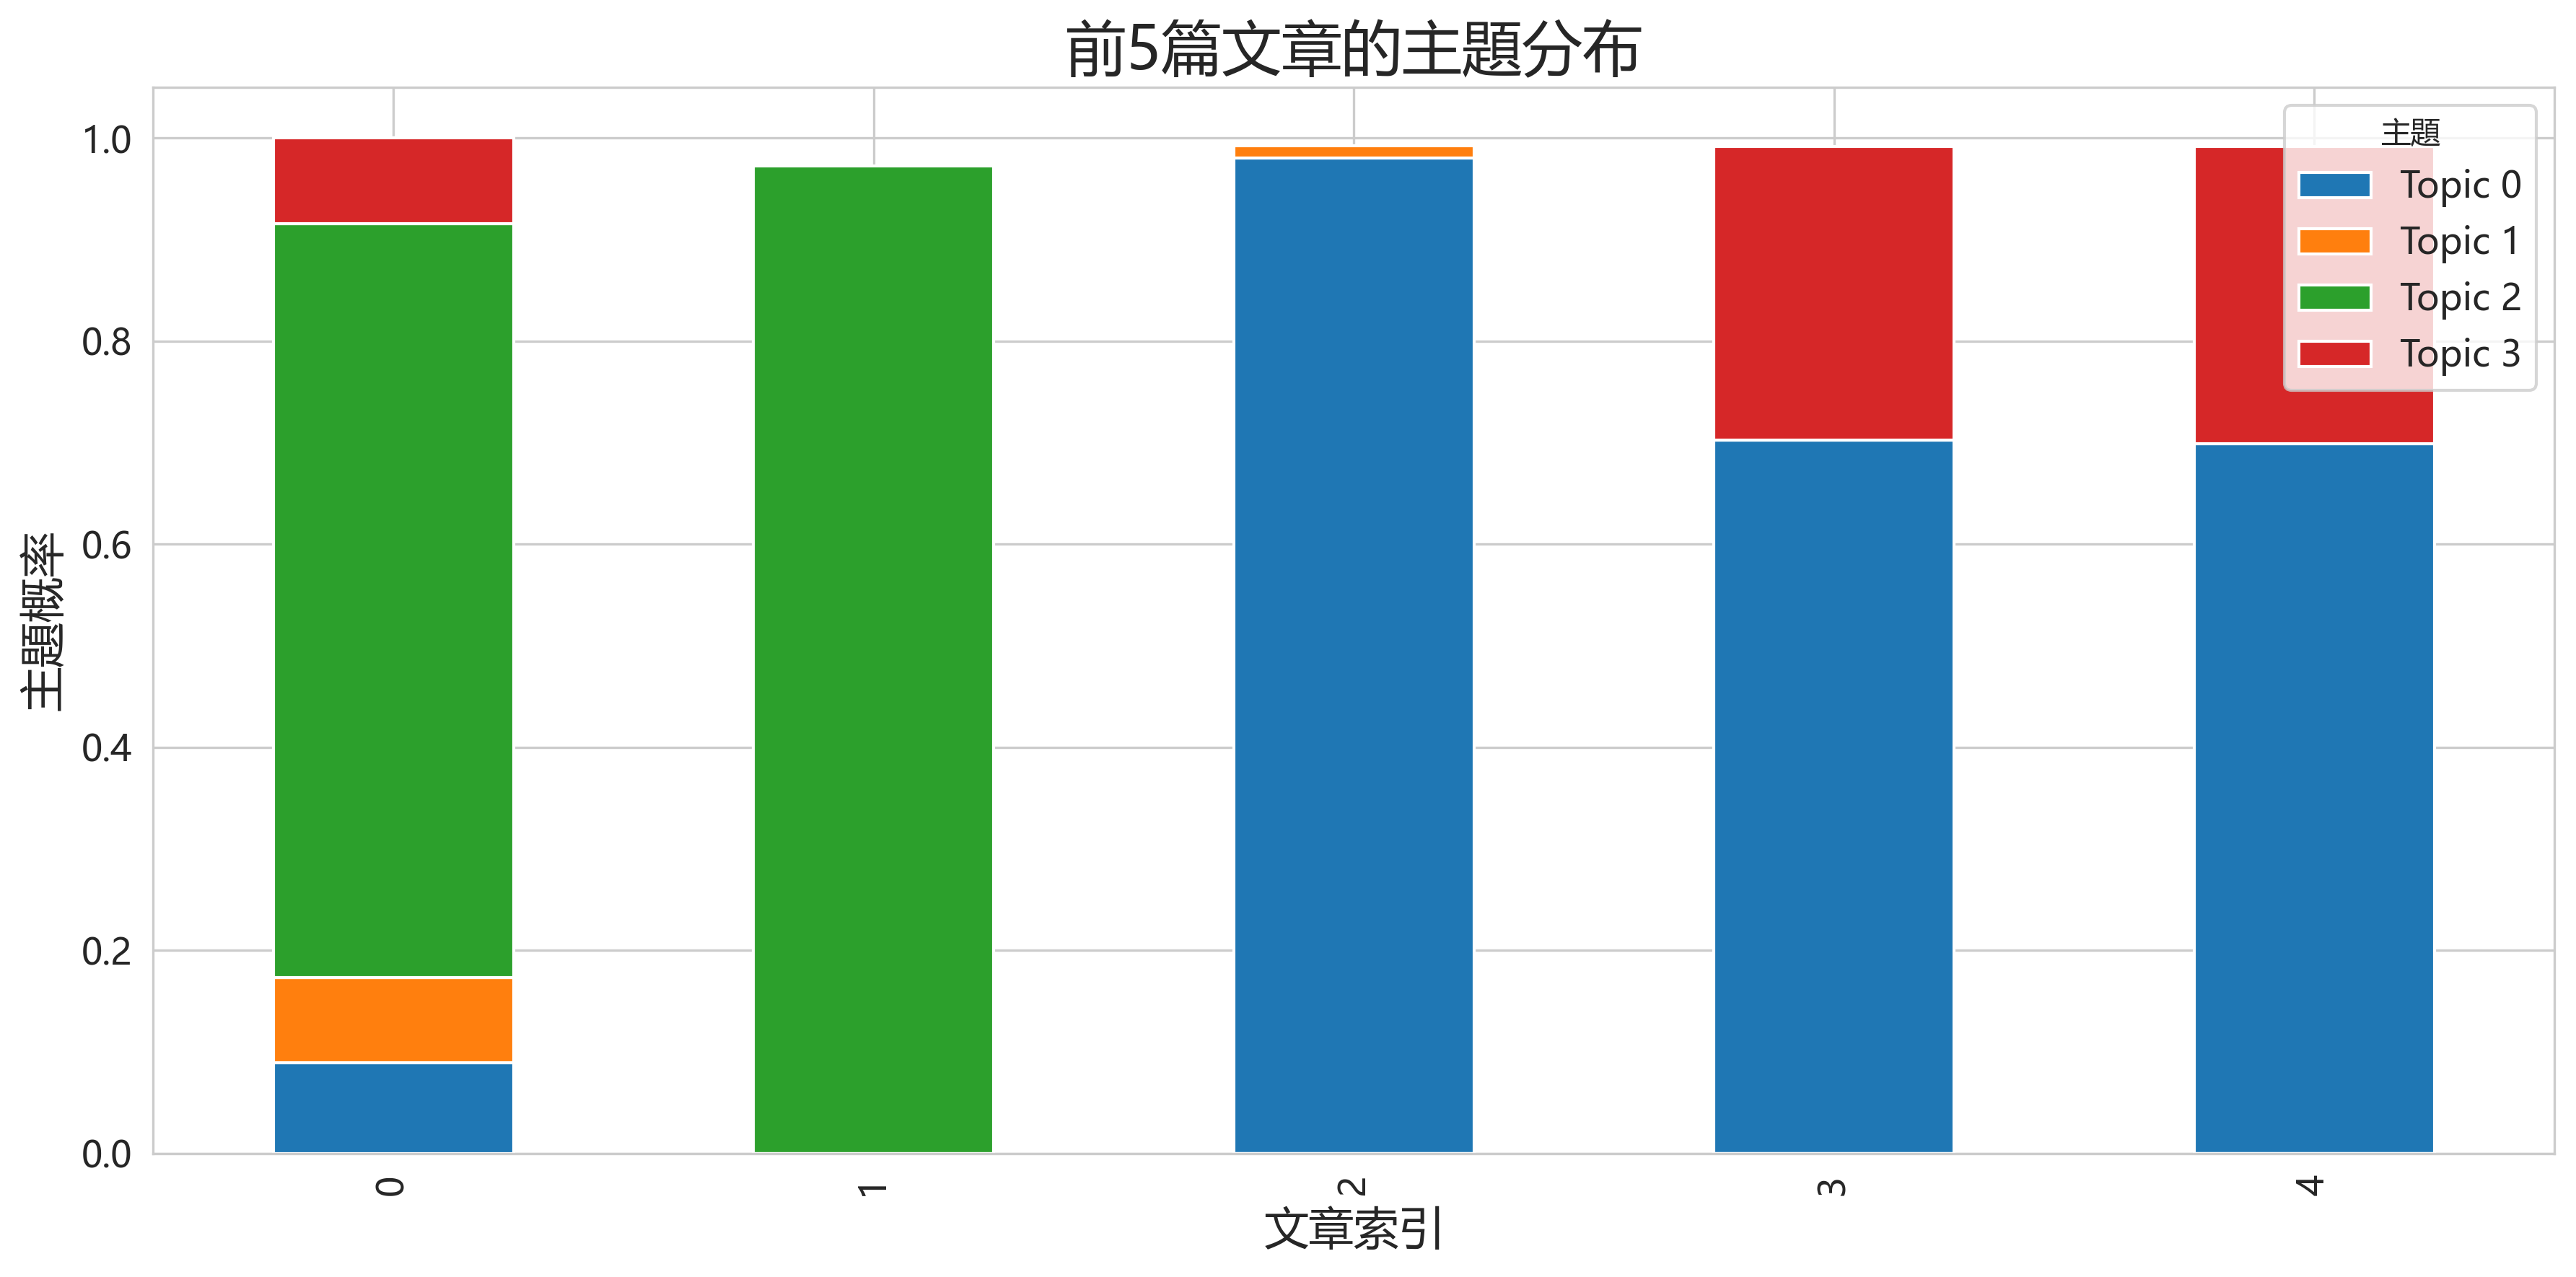

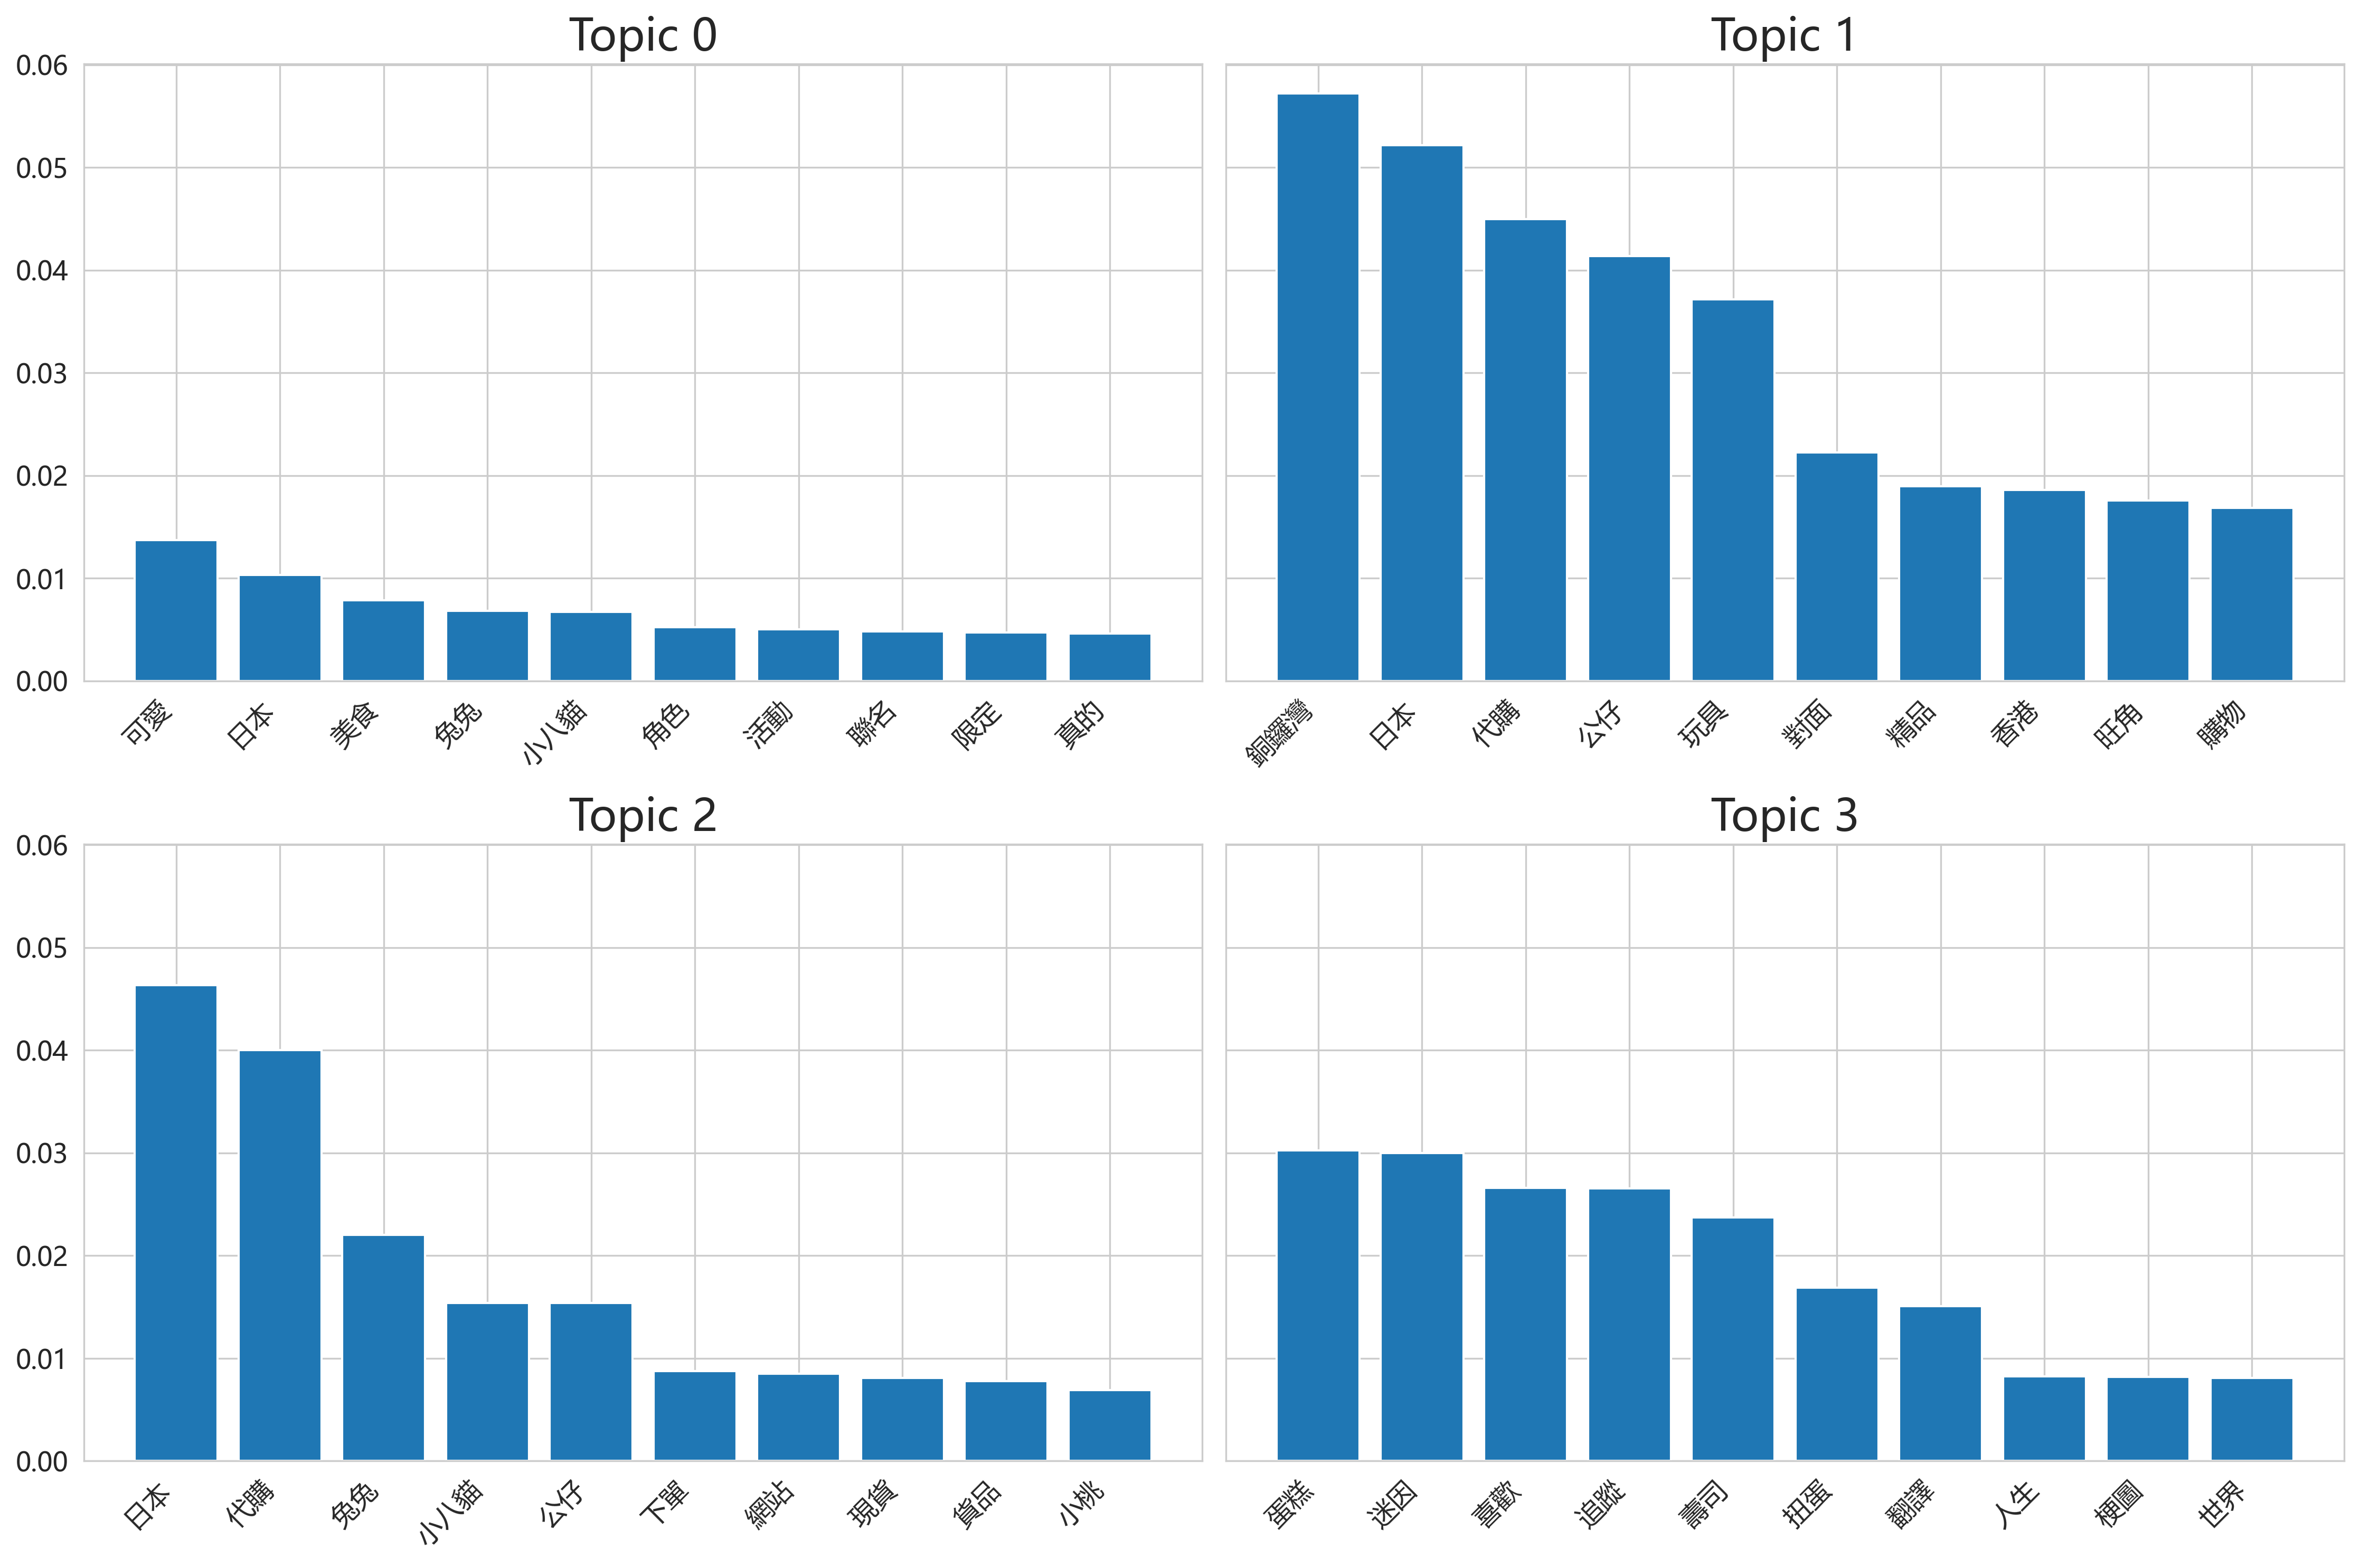

In [13]:
# 生成pyLDAvis視覺化
vis_data = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary, n_jobs=1)
pyLDAvis.display(vis_data)

# 保存視覺化結果到HTML文件
pyLDAvis.save_html(vis_data, 'lda_visualization.html')
print("LDA視覺化結果已保存到 'lda_visualization.html'")

# 視覺化每篇文章的主題分布
def get_document_topics(lda_model, corpus, n_docs=5):
    doc_topics = []
    for i, doc in enumerate(corpus[:n_docs]):  # 只取前n_docs篇文章
        topic_probs = lda_model.get_document_topics(doc)
        # 將主題概率轉為字典
        topic_dict = {f"Topic {topic_id}": prob for topic_id, prob in topic_probs}
        doc_topics.append(topic_dict)
    return pd.DataFrame(doc_topics)

# 獲取前5篇文章的主題分布
doc_topics_df = get_document_topics(best_model, corpus)
print("前5篇文章的主題分布:")
print(doc_topics_df)

# 視覺化前5篇文章的主題分布
doc_topics_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('前5篇文章的主題分布')
plt.xlabel('文章索引')
plt.ylabel('主題概率')
plt.legend(title='主題')
plt.tight_layout()
plt.show()

# 主題詞可視化
topics = best_model.show_topics(formatted=False, num_topics=best_num_topics, num_words=10)
fig, axes = plt.subplots(2, (best_num_topics+1)//2, figsize=(15, 10), sharey=True)
axes = axes.flatten()

for i, (topic_id, topic_words) in enumerate(topics):
    words = [word for word, _ in topic_words]
    weights = [weight for _, weight in topic_words]
    
    axes[i].bar(range(len(words)), weights, tick_label=words)
    axes[i].set_title(f'Topic {topic_id}')
    axes[i].set_xticklabels(words, rotation=45, ha='right')

plt.tight_layout()
plt.show()


2025-05-01 13:48:22,822 : INFO : n_documents: 12446
2025-05-01 13:48:22,824 : INFO : vocab_size: 9366
2025-05-01 13:48:22,824 : INFO : n_words: 541215
2025-05-01 13:48:22,825 : INFO : n_topics: 4
2025-05-01 13:48:22,825 : INFO : n_iter: 150
2025-05-01 13:48:22,828 : WARNING : all zero row in document-term matrix found
2025-05-01 14:09:04,366 : INFO : <0> log likelihood: -5122356


ValueError: x must be strictly positive

Exception ignored in: 'guidedlda._guidedlda.lgamma'
ValueError: x must be strictly positive
2025-05-01 14:09:04,839 : INFO : <20> log likelihood: -4004154


ValueError: x must be strictly positive

Exception ignored in: 'guidedlda._guidedlda.lgamma'
ValueError: x must be strictly positive
2025-05-01 14:09:05,258 : INFO : <40> log likelihood: -3941664


ValueError: x must be strictly positive

Exception ignored in: 'guidedlda._guidedlda.lgamma'
ValueError: x must be strictly positive
2025-05-01 14:09:05,676 : INFO : <60> log likelihood: -3915572


ValueError: x must be strictly positive

Exception ignored in: 'guidedlda._guidedlda.lgamma'
ValueError: x must be strictly positive
2025-05-01 14:09:06,094 : INFO : <80> log likelihood: -3901119


ValueError: x must be strictly positive

Exception ignored in: 'guidedlda._guidedlda.lgamma'
ValueError: x must be strictly positive
2025-05-01 14:09:06,509 : INFO : <100> log likelihood: -3894404


ValueError: x must be strictly positive

Exception ignored in: 'guidedlda._guidedlda.lgamma'
ValueError: x must be strictly positive
2025-05-01 14:09:06,925 : INFO : <120> log likelihood: -3889245


ValueError: x must be strictly positive

Exception ignored in: 'guidedlda._guidedlda.lgamma'
ValueError: x must be strictly positive
2025-05-01 14:09:07,335 : INFO : <140> log likelihood: -3885108


ValueError: x must be strictly positive

Exception ignored in: 'guidedlda._guidedlda.lgamma'
ValueError: x must be strictly positive
2025-05-01 14:09:07,544 : INFO : <149> log likelihood: -3883470
2025-05-01 14:09:07,615 : WARNING : all zero row in document-term matrix found


主題 #0:  喜歡, 小八貓, 兔兔, 迷因, 追蹤, 日本, 可愛, 翻譯, 角色, 世界
主題 #1:  日本, 銅鑼灣, 代購, 公仔, 玩具, 精品, 對面, 香港, 兔兔, 購物
主題 #2:  蛋糕, 查詢, 美甲, 代購, 日本, 門市, 手工, 商品, 香港, 出口
主題 #3:  日本, 可愛, 美食, 壽司, 活動, 扭蛋, 聯名, 限定, 東京, 高雄
    Topic 0   Topic 1   Topic 2   Topic 3
0  0.987967  0.003176  0.001417  0.007440
1  0.266097  0.000883  0.000035  0.732985
2  0.000100  0.016962  0.000059  0.982878
3  0.853202  0.000010  0.000044  0.146744
4  0.979232  0.000008  0.000047  0.020713


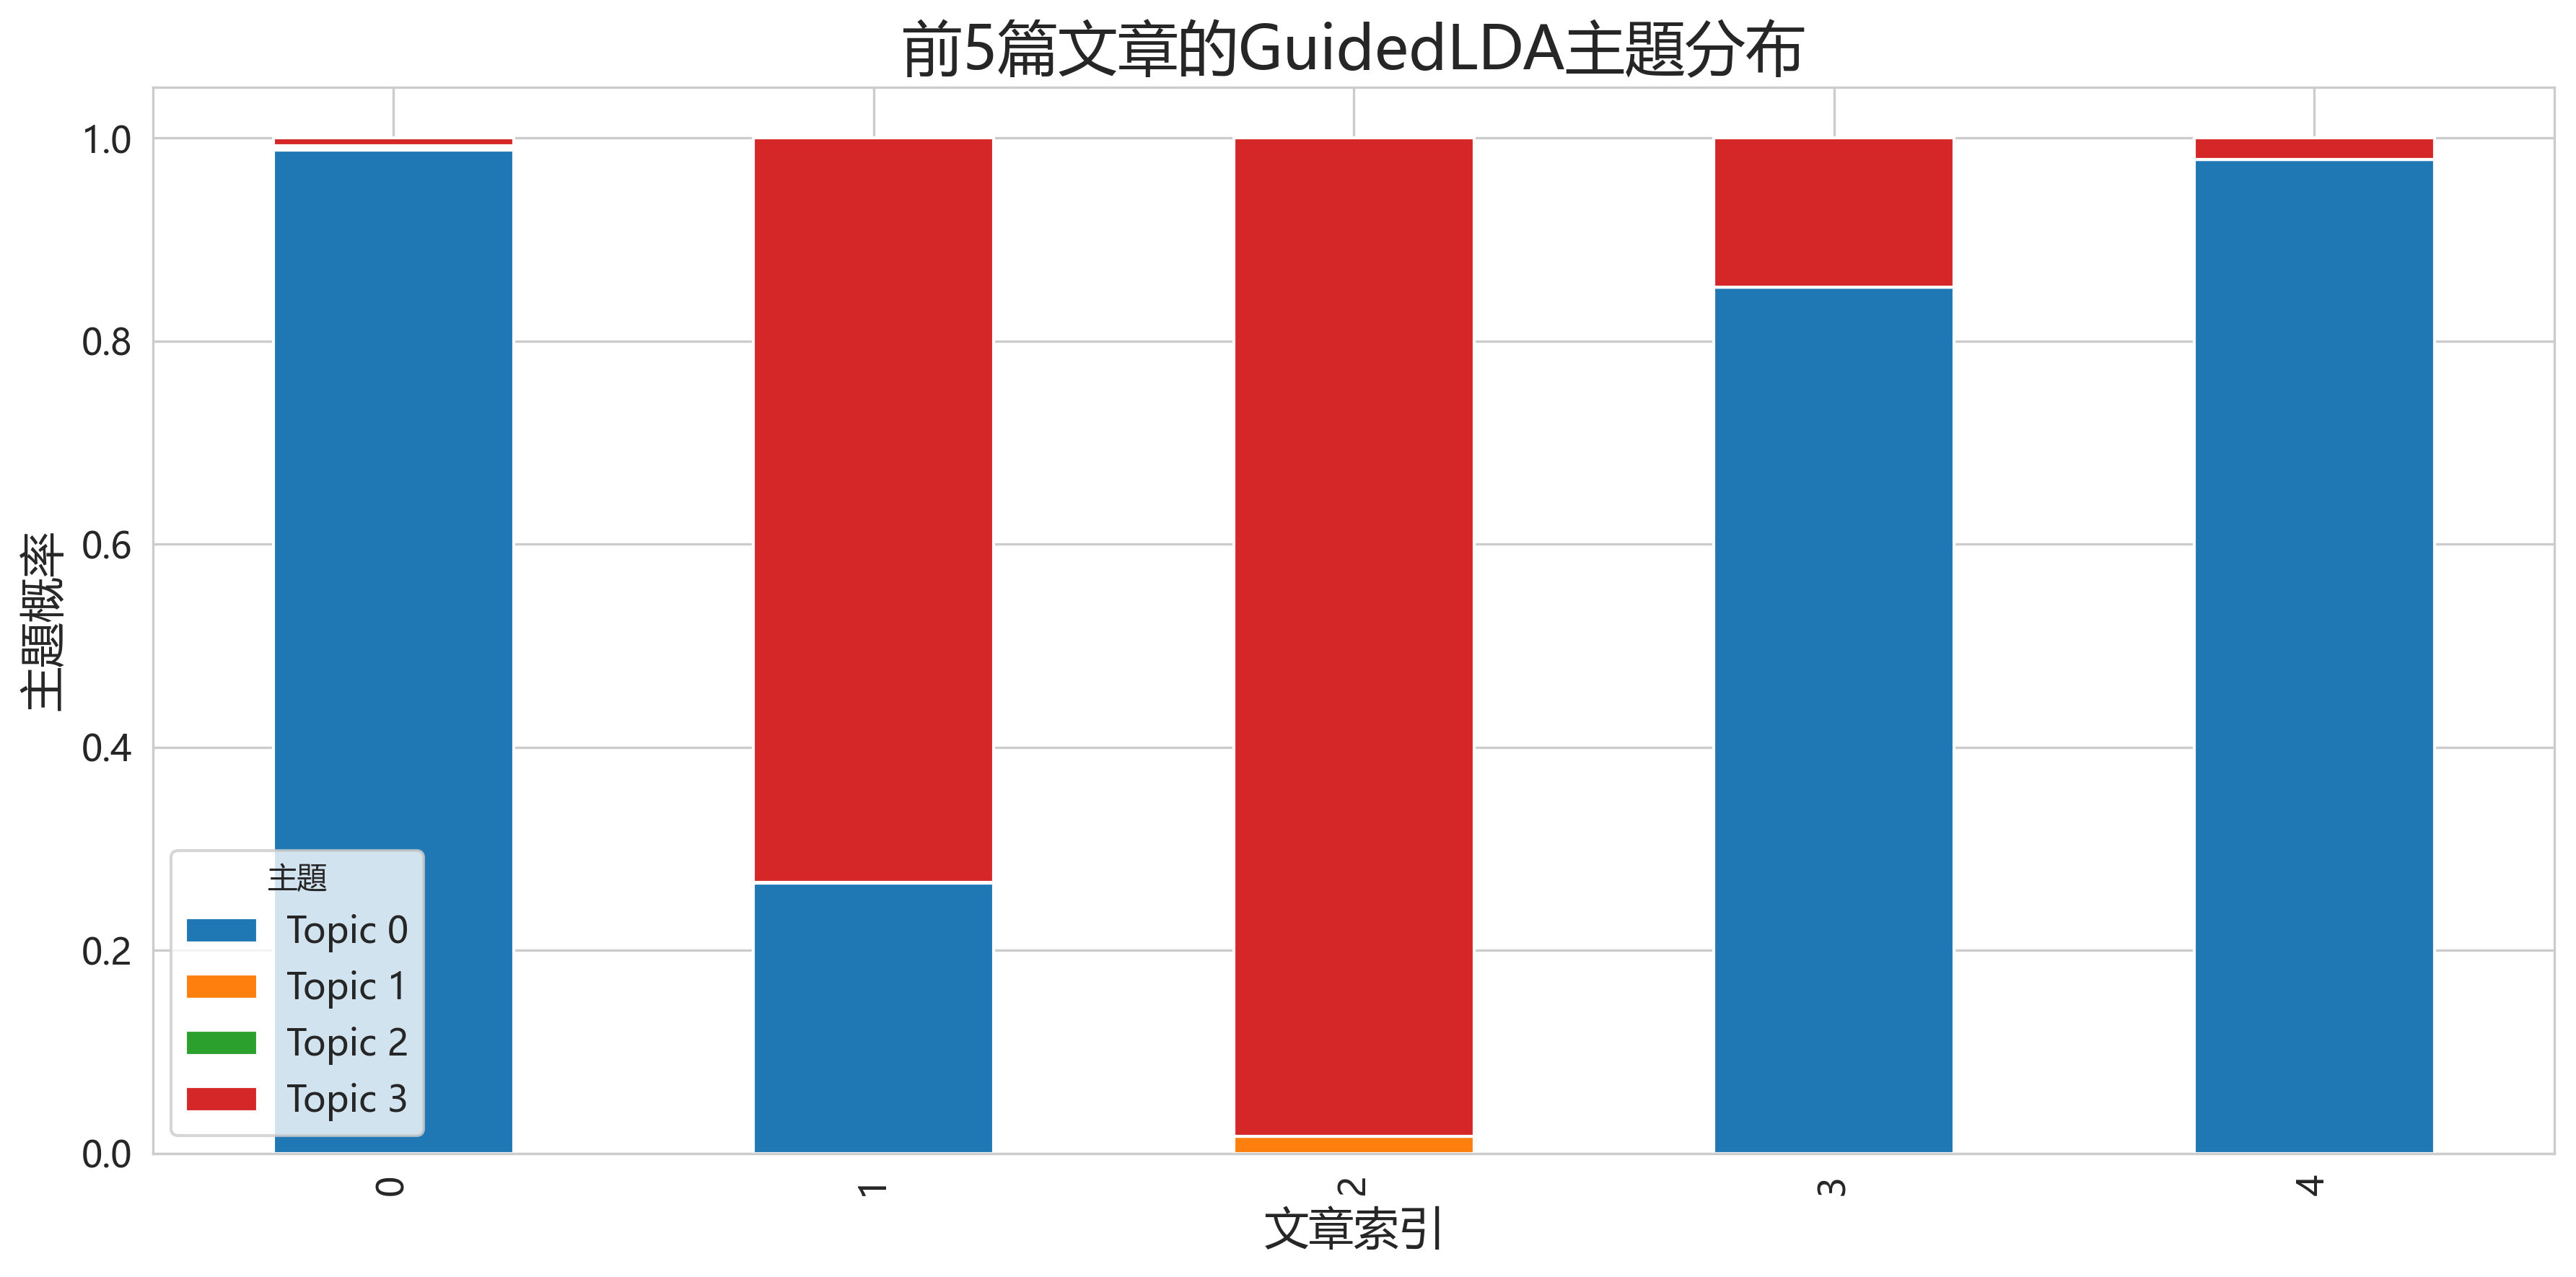

In [ ]:
# Corpus to csc matrix (文件數, 詞彙數)
X = corpus2csc(corpus, num_terms=len(dictionary)).T  
X = X.astype(np.int32)

# 設定種子詞與 topic 對應，確保清晰區分
character_words = ['小八貓', '兔兔', '角色', '迷因', '翻譯', '追蹤', '漫畫', '卡通', '可愛', '風獅']
shopping_words = ['銅鑼灣', '代購', '香港', '對面', '門市', '查詢', '出口', '現貨', '網站', '下單']
product_words = ['公仔', '玩具', '精品', '蛋糕', '美甲', '手工', '商品', '周邊', '扭蛋', '娃娃']
event_words = ['美食', '壽司', '活動', '聯名', '限定', '東京', '高雄', '展覽', '體驗', '季節']

word2id = dictionary.token2id
n_topics = 4

# 準備一個長度為詞彙表長度的 seed_topics 陣列，預設全部 -1
seed_topics = [-1] * len(dictionary)
# 將每個主題的種子詞貼到對應的位置
for word in character_words:
    if word in word2id:
        seed_topics[word2id[word]] = 0
for word in shopping_words:
    if word in word2id:
        seed_topics[word2id[word]] = 1
for word in product_words:
    if word in word2id:
        seed_topics[word2id[word]] = 2
for word in event_words:
    if word in word2id:
        seed_topics[word2id[word]] = 3

# 建立 GuidedLDA 模型，增加迭代次數
glda = guidedlda.GuidedLDA(n_topics=n_topics, n_iter=250, random_state=42, refresh=20,alpha=0.1)

# 訓練
glda.fit(X, seed_topics=seed_topics, seed_confidence=0.5)

# 查看主題 top 詞
vocab = [dictionary[i] for i in range(len(dictionary))]
for t in range(n_topics):
    top_word_ids = glda.topic_word_[t].argsort()[::-1][:10]
    print(f"主題 #{t}: ", ', '.join(vocab[i] for i in top_word_ids))

# print出每篇文章的主題分布
doc_topic = glda.transform(X)
df_guided_topics = pd.DataFrame(doc_topic[:5], columns=[f'Topic {i}' for i in range(n_topics)])
print(df_guided_topics)

# Plot
df_guided_topics.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('前5篇文章的GuidedLDA主題分布')
plt.xlabel('文章索引')
plt.ylabel('主題概率')
plt.legend(title='主題')
plt.tight_layout()
plt.show()


2025-05-01 14:31:43,058 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-01 14:31:43,061 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-01 14:31:43,064 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-01 14:31:43,066 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-01 14:31:43,068 : INFO : Using categorical units to plot a list of strings that are all parsable as 

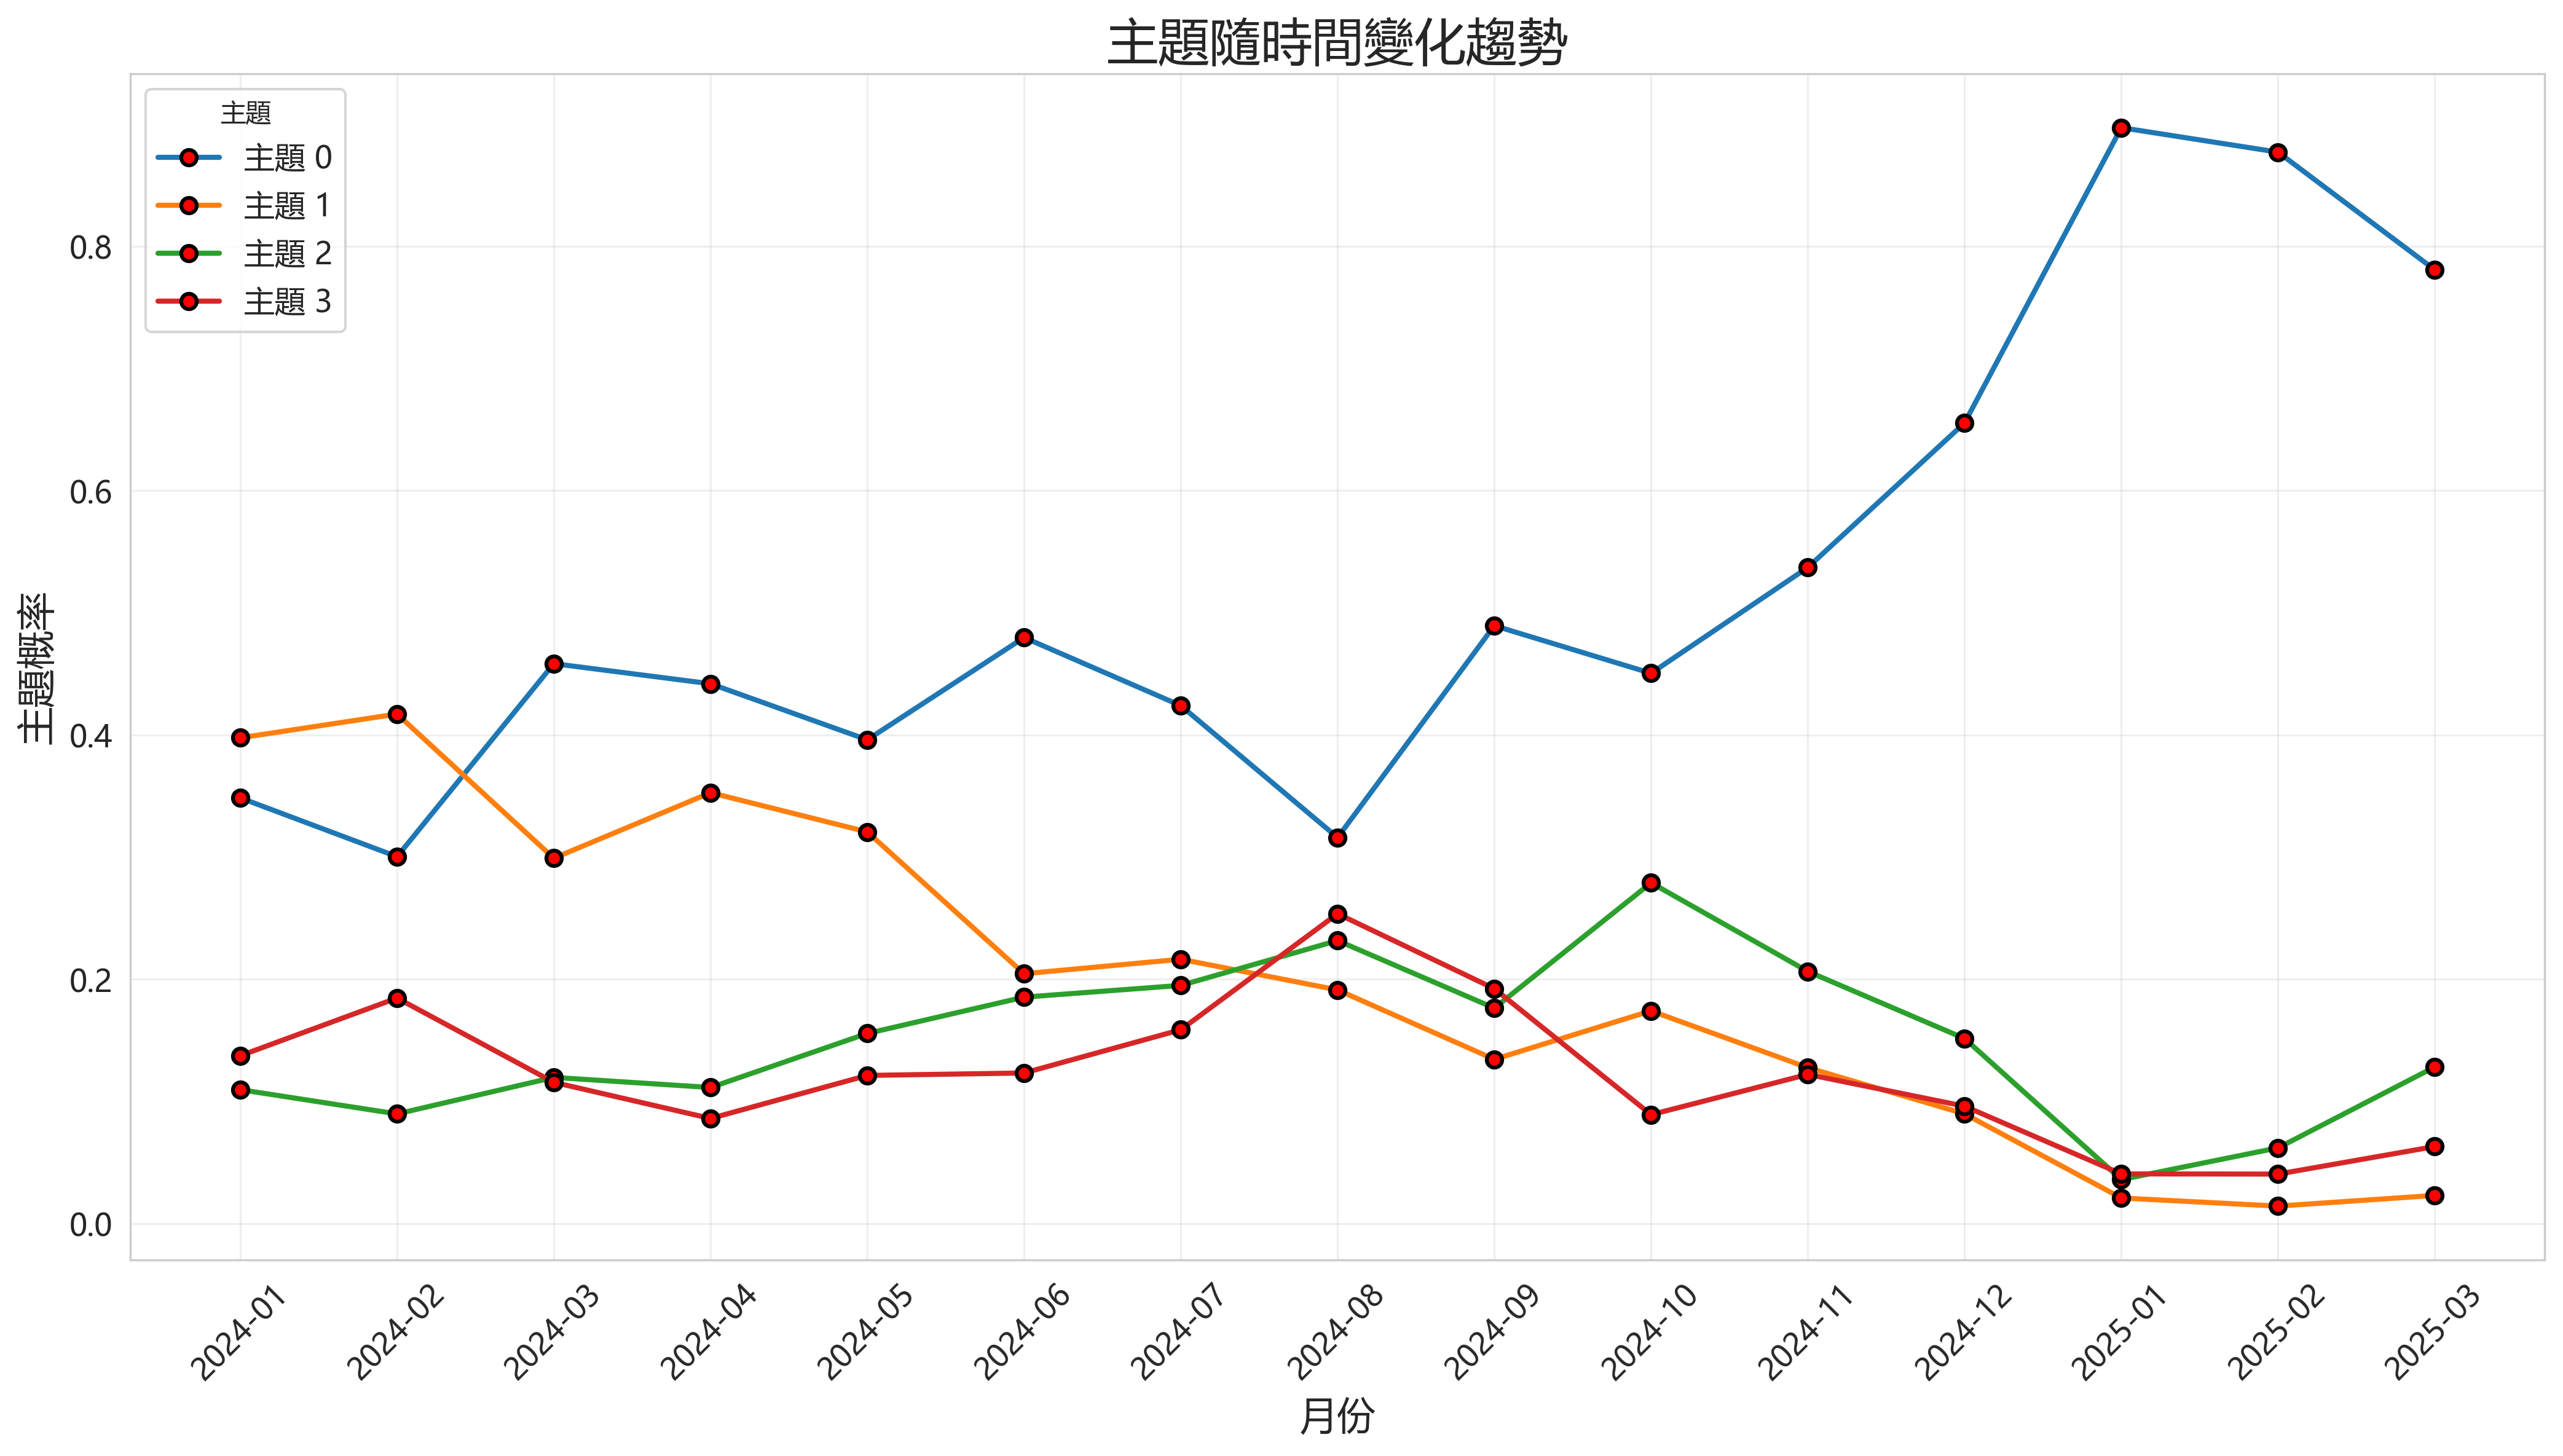

隨機選擇的文章:
標題: nan
內容: 太中肯

喜歡吉伊卡哇追蹤👉 chiikawa_twlove 
喜歡阿甘妙世界追蹤👉 gumball_tw666 

#迷因 #迷因梗圖 #翻譯迷因 #迷因翻譯 #梗圖 #幽默人生 #搞笑...

推薦的相似文章:
1. 標題: nan
   相似度: 1.0000
   內容: 太中肯

喜歡吉伊卡哇追蹤👉 chiikawa_twlove 
喜歡阿甘妙世界追蹤👉 gumball_tw666 

#迷因 #迷因梗圖 #翻譯迷因 #迷因翻譯 #梗圖 #幽默人生 #搞笑...

2. 標題: nan
   相似度: 1.0000
   內容: 太中肯

喜歡吉伊卡哇追蹤👉 chiikawa_twlove 
喜歡阿甘妙世界追蹤👉 gumball_tw666 

#迷因 #迷因梗圖 #翻譯迷因 #迷因翻譯 #梗圖 #幽默人生 #搞笑...

3. 標題: nan
   相似度: 1.0000
   內容: 這太客家了

喜歡吉伊卡哇追蹤👉 chiikawa_twlove 
喜歡阿甘妙世界追蹤👉 gumball_tw666 

#迷因 #迷因梗圖 #翻譯迷因 #迷因翻譯 #梗圖 #幽默人生 #搞笑...

4. 標題: nan
   相似度: 1.0000
   內容: 這太客家了

喜歡吉伊卡哇追蹤👉 chiikawa_twlove 
喜歡阿甘妙世界追蹤👉 gumball_tw666 

#迷因 #迷因梗圖 #翻譯迷因 #迷因翻譯 #梗圖 #幽默人生 #搞笑...

5. 標題: nan
   相似度: 1.0000
   內容: 這太客家了

喜歡吉伊卡哇追蹤👉 chiikawa_twlove 
喜歡阿甘妙世界追蹤👉 gumball_tw666 

#迷因 #迷因梗圖 #翻譯迷因 #迷因翻譯 #梗圖 #幽默人生 #搞笑...



In [15]:
# 分析主題隨時間變化
df['artDate'] = pd.to_datetime(df['artDate'])
df['month'] = df['artDate'].dt.to_period('M')

# 獲取每篇文章的主題分布
doc_topics = []
for doc in corpus:
    topic_probs = best_model.get_document_topics(doc)
    # 創建一個值為0的向量
    topic_vec = [0] * best_num_topics
    # 填充主題概率
    for topic_id, prob in topic_probs:
        topic_vec[topic_id] = prob
    doc_topics.append(topic_vec)

# 將主題分布添加到數據框
topic_cols = [f'Topic_{i}' for i in range(best_num_topics)]
df_topics = pd.DataFrame(doc_topics, columns=topic_cols)
df = pd.concat([df.reset_index(drop=True), df_topics.reset_index(drop=True)], axis=1)

# 計算每月的主題分布
monthly_topics = df.groupby('month')[topic_cols].mean()

# 繪製主題隨時間變化的趨勢圖
plt.figure(figsize=(14, 8))
for i, topic in enumerate(topic_cols):
    plt.plot(monthly_topics.index.astype(str), monthly_topics[topic], 'o-', label=f'主題 {i}')

plt.title('主題隨時間變化趨勢')
plt.xlabel('月份')
plt.ylabel('主題概率')
plt.legend(title='主題')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 主題與情感關聯分析
if 'sentiment_score' in df.columns:
    # 計算每個主題與情感分數的相關性
    topic_sentiment_corr = df[topic_cols + ['sentiment_score']].corr()['sentiment_score'][:-1]
    
    # 可視化主題與情感的相關性
    plt.figure(figsize=(10, 6))
    topic_sentiment_corr.plot(kind='bar')
    plt.title('主題與情感分數的相關性')
    plt.xlabel('主題')
    plt.ylabel('與情感分數的相關係數')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 對主題進行情感分類
    print("基於相關性的主題情感分類:")
    for topic, corr in topic_sentiment_corr.items():
        sentiment = "正面" if corr > 0.1 else "負面" if corr < -0.1 else "中性"
        print(f"{topic}: {sentiment} (相關係數: {corr:.4f})")

# 文檔推薦系統
from sklearn.metrics.pairwise import cosine_similarity

# 計算文檔間的相似度
doc_topic_matrix = np.array(doc_topics)
doc_sim = cosine_similarity(doc_topic_matrix)

# 為每篇文章推薦相似文章
def recommend_similar_articles(doc_index, doc_sim_matrix, df, top_n=5):
    """基於主題相似度為指定文章推薦相似文章"""
    # 獲取相似度排序（不包含自己）
    similar_indices = doc_sim_matrix[doc_index].argsort()[::-1][1:top_n+1]
    
    # 獲取相似文章的信息
    similar_articles = df.iloc[similar_indices][['artTitle', 'artContent']]
    similar_scores = doc_sim_matrix[doc_index][similar_indices]
    
    # 添加相似度分數
    similar_articles = similar_articles.copy()
    similar_articles['similarity_score'] = similar_scores
    
    return similar_articles

# 隨機選擇一篇文章並推薦相似文章
sample_doc_index = np.random.randint(0, len(df))
print(f"隨機選擇的文章:")
print(f"標題: {df.iloc[sample_doc_index]['artTitle']}")
print(f"內容: {df.iloc[sample_doc_index]['artContent'][:200]}...")

similar_articles = recommend_similar_articles(sample_doc_index, doc_sim, df)
print("\n推薦的相似文章:")
for i, (_, article) in enumerate(similar_articles.iterrows()):
    print(f"{i+1}. 標題: {article['artTitle']}")
    print(f"   相似度: {article['similarity_score']:.4f}")
    print(f"   內容: {article['artContent'][:100]}...")
    print()